In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely
import matplotlib.pyplot as plt
from shapely.geometry import Point


from scipy.stats import chi2
from matplotlib.patches import Ellipse
import plotly.graph_objs as go


# Transformacion de Puntos a Coordenadas

In [2]:
# Leer el catalogo donde vienen los puntos
df = pd.read_csv('/home/jbg/Documents/geofisica_lapaz/conversioncoordenadas/resultado_sismos.csv')

In [3]:
#Identificar columnas
df.columns

Index(['trace_coda_end_sample', 'source_depth_km', 'source_latitude_deg',
       'source_longitude_deg', 'source_magnitude', 'source_origin_time',
       'trace_p_arrival_sample', 'trace_p_arrival_time',
       'trace_p_arrival_uncertainty_s', 'trace_s_arrival_sample',
       'trace_s_arrival_time', 'trace_s_arrival_uncertainty_s', 'trace_snr_db',
       'station_elevation_m', 'station_latitude_deg', 'station_longitude_deg',
       'station_code', 'trace_category', 'trace_name_original', 'split',
       'trace_name', 'trace_causal', 'trace_polarity', 'ID_poligono'],
      dtype='object')

In [4]:
# Agregar una columna de geometría a partir de las columnas de coordenadas
geometry = [Point(xy) for xy in zip(df['source_longitude_deg'], df['source_latitude_deg'])]

In [5]:
# Convertir en un geodataframe para incluir el crs
gdf = gpd.GeoDataFrame(df, geometry=geometry)

In [6]:
# Seleccionar el crs en que se encuentran los datos
# EPSG:4326 - WGS84
gdf.set_crs(epsg=4326, inplace=True).head(5)

,trace_coda_end_sample,source_depth_km,source_latitude_deg,source_longitude_deg,source_magnitude,source_origin_time,trace_p_arrival_sample,trace_p_arrival_time,trace_p_arrival_uncertainty_s,trace_s_arrival_sample,...,station_longitude_deg,station_code,trace_category,trace_name_original,split,trace_name,trace_causal,trace_polarity,ID_poligono,geometry
0,1530.0,5.643115,31.244769,-103.553538,1.413654,2019-04-02T03:34:48.725819Z,1034.0,2019-04-02T03:34:52.621560Z,0.2,1282.0,...,-103.510147,PCOS,earthquake_local,texnet2019gknw_PCOS_EV,train,"bucket268$338,:3,:6000",unknown,unknown,3,POINT (-103.55354 31.24477)
1,646.0,3.072314,31.445149,-103.586818,1.343138,2019-04-02T15:44:47.758892Z,398.0,2019-04-02T15:44:49.774274Z,0.2,522.0,...,-103.510147,PCOS,earthquake_local,texnet2019glly_PCOS_EV,train,"bucket268$343,:3,:6000",unknown,unknown,4,POINT (-103.58682 31.44515)
2,1357.0,6.157275,31.274182,-103.572833,1.532322,2019-04-03T00:19:32.460730Z,863.0,2019-04-03T00:19:35.861650Z,0.3,1110.0,...,-103.510147,PCOS,earthquake_local,texnet2019gmcy_PCOS_EV,test,"bucket267$962,:3,:6000",unknown,unknown,3,POINT (-103.57283 31.27418)
3,1602.0,5.540283,31.253961,-103.559968,2.021868,2019-04-03T02:49:31.391207Z,962.0,2019-04-03T02:49:34.487029Z,0.3,1282.0,...,-103.510147,PCOS,earthquake_local,texnet2019gmhw_PCOS_EV,train,"bucket268$388,:3,:6000",unknown,unknown,3,POINT (-103.55997 31.25396)
4,959.0,6.131567,31.250054,-103.556485,1.866408,2019-04-03T04:07:27.403390Z,427.0,2019-04-03T04:07:31.281541Z,0.2,693.0,...,-103.510147,PCOS,earthquake_local,texnet2019gmkl_PCOS_EV,train,"bucket268$401,:3,:6000",unknown,unknown,3,POINT (-103.55649 31.25005)


# Transformacion de coordenadas

In [7]:
# Convertir a otro CRS, por ejemplo, a UTM zona (EPSG:32614)13 N
# En este caso los puntos ocurren entre dos zonas, entonces se elige una projeccion que abarque todos los puntos como:
# EPSG:3081: NAD83 / Texas Centric Albers Equal Area.  https://epsg.io/3081-1735
gdf_utm = gdf.to_crs(epsg=3081)


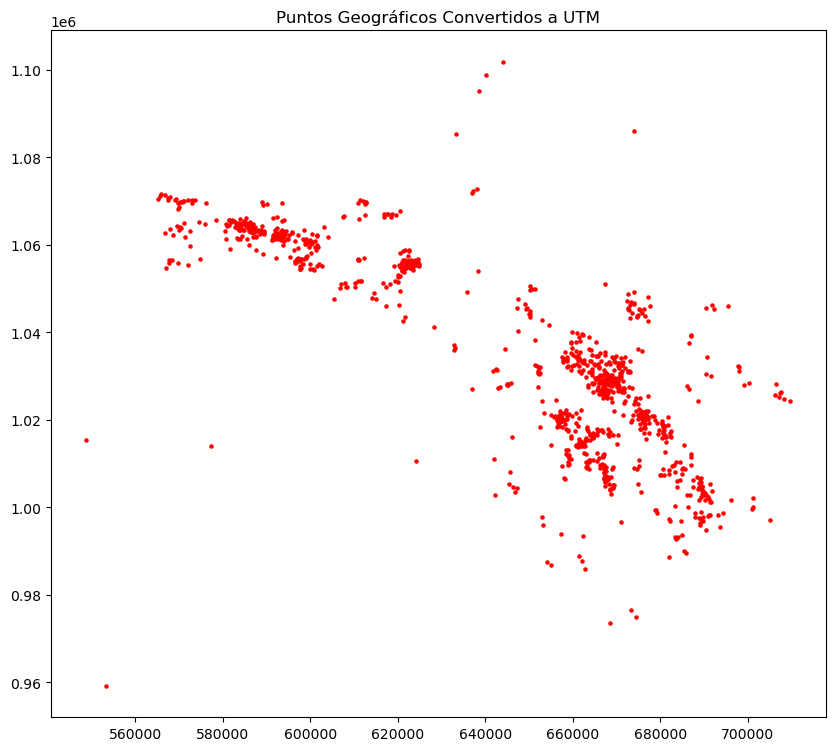

In [8]:
# Graficar los puntos
fig, ax = plt.subplots(figsize=(10, 10))
gdf_utm.plot(ax=ax,marker='o', color='red', markersize=5)
plt.title("Puntos Geográficos Convertidos a UTM")
plt.show()

# Redefinir el punto de origen de las coordenadas 

In [9]:
x_offset = 550000  # Restar metros en X
y_offset = 958000   # Restar metros en Y

gdf_utm['geometry'] = gdf_utm['geometry'].apply(lambda geom: Point(geom.x - x_offset, geom.y - y_offset))
# Alternativamente, si tienes líneas o polígonos, usar translate
# gdf['geometry'] = gdf['geometry'].translate(xoff=-x_offset, yoff=-y_offset)


# Convertir a puntos

In [10]:
gdf_utm['X'] = gdf_utm.geometry.x
gdf_utm['Y'] = gdf_utm.geometry.y
gdf_utm.head(3)

,trace_coda_end_sample,source_depth_km,source_latitude_deg,source_longitude_deg,source_magnitude,source_origin_time,trace_p_arrival_sample,trace_p_arrival_time,trace_p_arrival_uncertainty_s,trace_s_arrival_sample,...,trace_category,trace_name_original,split,trace_name,trace_causal,trace_polarity,ID_poligono,geometry,X,Y
0,1530.0,5.643115,31.244769,-103.553538,1.413654,2019-04-02T03:34:48.725819Z,1034.0,2019-04-02T03:34:52.621560Z,0.2,1282.0,...,earthquake_local,texnet2019gknw_PCOS_EV,train,"bucket268$338,:3,:6000",unknown,unknown,3,POINT (112271.307 56065.574),112271.306849,56065.574137
1,646.0,3.072314,31.445149,-103.586818,1.343138,2019-04-02T15:44:47.758892Z,398.0,2019-04-02T15:44:49.774274Z,0.2,522.0,...,earthquake_local,texnet2019glly_PCOS_EV,train,"bucket268$343,:3,:6000",unknown,unknown,4,POINT (109828.121 78325.881),109828.120871,78325.881200
2,1357.0,6.157275,31.274182,-103.572833,1.532322,2019-04-03T00:19:32.460730Z,863.0,2019-04-03T00:19:35.861650Z,0.3,1110.0,...,earthquake_local,texnet2019gmcy_PCOS_EV,test,"bucket267$962,:3,:6000",unknown,unknown,3,POINT (110543.245 59377.175),110543.244875,59377.175300


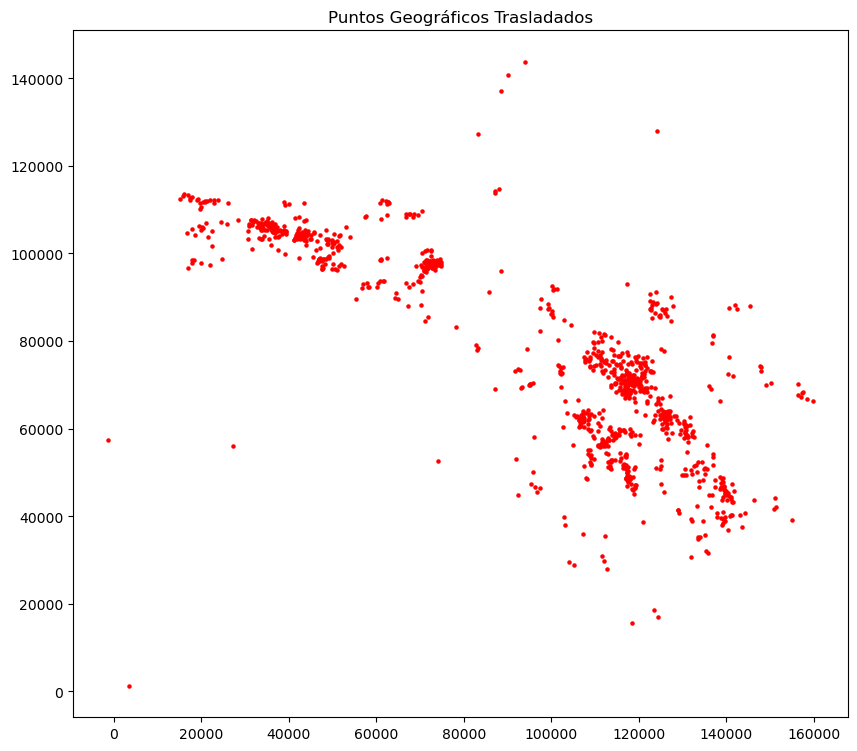

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_utm.plot(ax=ax,marker='o', color='red', markersize=5)
plt.title("Puntos Geográficos Trasladados")
plt.show()

### Funciones que resumen el proceso

In [3]:
def transformacion_coordenadas(csvdata, x_offset, y_offset, epsg_in=4326, epsg_out=32613):
    geometry = [Point(xy) for xy in zip(csvdata['source_longitude_deg'], csvdata['source_latitude_deg'])]
    gdf = gpd.GeoDataFrame(csvdata, geometry=geometry)
    gdf.set_crs(epsg=epsg_in, inplace=True)
    gdf_utm = gdf.to_crs(epsg=epsg_out)
    gdf_utm['geometry'] = gdf_utm['geometry'].apply(lambda geom: Point(geom.x - x_offset, geom.y - y_offset))
    gdf_utm['X'] = gdf_utm.geometry.x
    gdf_utm['Y'] = gdf_utm.geometry.y
    return gdf_utm

def revese_transformacion_coordenadas(plaindata, x_offset, y_offset, epsg_in=32613, epsg_out=4326 ):
    geometry = [Point(xy) for xy in zip(plaindata['X'], plaindata['Y'])]
    geodata = gpd.GeoDataFrame(plaindata, geometry=geometry)
    geodata.set_crs(epsg=epsg_in, inplace=True)
    geodata['geometry'] = geodata['geometry'].apply(lambda geom: Point(geom.x + x_offset, geom.y + y_offset))
    geodata = geodata.to_crs(epsg=epsg_out)
    return geodata

In [13]:
False in gdf_utm == transformacion_coordenadas(df,550000,958000,epsg_out=3081)

False

In [14]:
False in gdf == revese_transformacion_coordenadas(gdf_utm,550000,958000,epsg_in=32613)

False

# Elipses de confianza

Ubicar co una estrella/cuadrada estacion PCOS:

Lat: 31.408922          lon: -103.510147

In [15]:
#Hacer la conversion
gdf_offset = transformacion_coordenadas(df,550000,958000,epsg_out=3081)

In [16]:
mean =[np.mean(gdf_offset.X), np.mean(gdf_offset.Y)]
cov = np.cov(gdf_offset.X,gdf_offset.Y)

In [17]:
cov

array([[ 1.40732748e+09, -6.94744848e+08],
       [-6.94744848e+08,  5.10753788e+08]])

In [18]:
from scipy.stats import chi2
from matplotlib.patches import Ellipse

confidence_level = 0.95
chi2_val = chi2.ppf(confidence_level, 2)

eigvals, eigvecs = np.linalg.eigh(cov)
order = eigvals.argsort()[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[:, order]

# Longitud de los ejes
width, height = 2 * np.sqrt(eigvals * chi2_val)

# Ángulo de rotación
angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

In [19]:
chi2_val

5.991464547107979

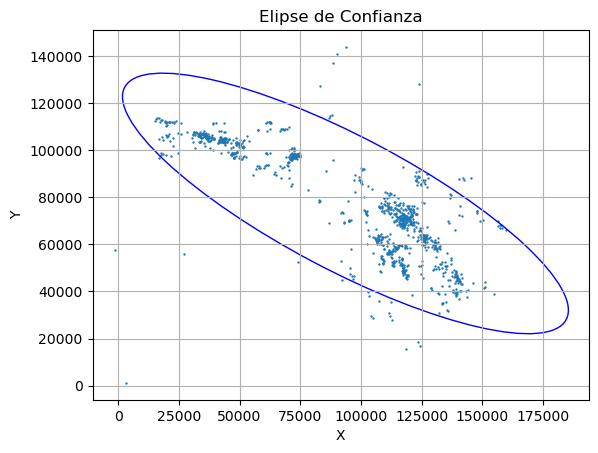

In [20]:
fig, ax = plt.subplots()

# Graficar los datos
ax.scatter(gdf_offset.X, gdf_offset.Y, s=0.5)

# Crear la elipse
ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='blue', facecolor='none')
ax.add_patch(ellipse)

# Configurar la gráfica
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Elipse de Confianza')
plt.grid(True)
plt.show()

# Esfera de confianza

In [21]:
#Hacer la conversion
gdf_offset = transformacion_coordenadas(df,550000,958000,epsg_out=3081)
mean =[np.mean(gdf_offset.X), np.mean(gdf_offset.Y),np.mean(gdf_offset.source_depth_km)*1000]
cov = np.cov([gdf_offset.X,gdf_offset.Y, gdf_offset.source_depth_km*1000])

In [26]:
print([gdf_offset.X,gdf_offset.Y, gdf_offset.source_depth_km*1000])

[0       112271.306849
1       109828.120871
2       110543.244875
3       111693.109149
4       112010.115277
            ...      
1041    102100.708592
1042    119198.907380
1043    117119.010672
1044     94535.171941
1045    126690.122298
Name: X, Length: 1046, dtype: float64, 0       56065.574137
1       78325.881200
2       59377.175300
3       57101.675645
4       56659.036763
            ...     
1041    69416.928919
1042    51213.029369
1043    51114.637861
1044    78207.650598
1045    57534.686154
Name: Y, Length: 1046, dtype: float64, 0       5643.115234
1       3072.314453
2       6157.275391
3       5540.283203
4       6131.567383
           ...     
1041    7905.419922
1042     450.097656
1043    4293.444824
1044     501.513672
1045    2043.994141
Name: source_depth_km, Length: 1046, dtype: float64]


In [ ]:
cov

array([[ 1.40732748e+09, -6.94744848e+08, -4.24513173e+07],
       [-6.94744848e+08,  5.10753788e+08,  2.56500786e+07],
       [-4.24513173e+07,  2.56500786e+07,  4.04026034e+06]])

In [28]:
confidence_level = 0.95
chi2_val = chi2.ppf(confidence_level, 3)


intervalo_radio = np.sqrt(chi2_val)

eigvals, eigvecs = np.linalg.eigh(cov)
order = eigvals.argsort()[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[:, order]

ejes_elipsoide = intervalo_radio * np.sqrt(eigvals)


In [33]:
import plotly.graph_objs as go

#Crear una malla de puntos para el elipsoide
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = ejes_elipsoide[0] * np.outer(np.cos(u), np.sin(v))
y = ejes_elipsoide[1] * np.outer(np.sin(u), np.sin(v))
z = ejes_elipsoide[2] * np.outer(np.ones_like(u), np.cos(v))

# Aplicar la rotación para alinear el elipsoide con los eigenvectores
elipsoide_rotado = np.dot(eigvecs, np.array([x.flatten(), y.flatten(), z.flatten()]))
x_rotado = elipsoide_rotado[0, :].reshape(x.shape) + mean[0]
y_rotado = elipsoide_rotado[1, :].reshape(y.shape) + mean[1]
z_rotado = elipsoide_rotado[2, :].reshape(z.shape) + mean[2]

fig = go.Figure()
fig.add_trace(go.Surface(x=x_rotado, y=y_rotado, z=z_rotado, opacity=0.5, colorscale='Viridis'))

fig.add_trace(go.Scatter3d(
    x=gdf_offset.X, 
    y=gdf_offset.Y, 
    z=gdf_offset.source_depth_km*1000, 
    mode='markers', 
    marker=dict(size=4, color='red')
))

fig.show()

# Lectura por zonas

In [8]:
# Leer el catalogo donde vienen los puntos
df = pd.read_csv('/home/jbg/Documents/geofisica_lapaz/conversioncoordenadas/resultado_sismos.csv')
#Hacer la conversion
gdf_offset = transformacion_coordenadas(df,550000,958000,epsg_out=3081)

#########################################################3
#Crear una malla de puntos para el elipsoide
mean =[np.mean(gdf_offset.X), np.mean(gdf_offset.Y),np.mean(gdf_offset.source_depth_km)*1000]
cov = np.cov([gdf_offset.X,gdf_offset.Y, gdf_offset.source_depth_km*1000])
confidence_level = 0.95
chi2_val = chi2.ppf(confidence_level, 3)
intervalo_radio = np.sqrt(chi2_val)
eigvals, eigvecs = np.linalg.eigh(cov)
order = eigvals.argsort()[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[:, order]
ejes_elipsoide = intervalo_radio * np.sqrt(eigvals)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = ejes_elipsoide[0] * np.outer(np.cos(u), np.sin(v))
y = ejes_elipsoide[1] * np.outer(np.sin(u), np.sin(v))
z = ejes_elipsoide[2] * np.outer(np.ones_like(u), np.cos(v))
fig = go.Figure()
###############################################



variables = {}
for i in range(8):
    i+=1
    data = gdf_offset[gdf_offset['ID_poligono'] == i]
    mean =[np.mean(data.X), np.mean(data.Y),np.mean(data.source_depth_km)*1000]
    cov = np.cov([data.X,data.Y, data.source_depth_km*1000])
    variables[f'poligono_{i}'] = cov

    confidence_level = 0.95
    chi2_val = chi2.ppf(confidence_level, 3)
    intervalo_radio = np.sqrt(chi2_val)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    ejes_elipsoide = intervalo_radio * np.sqrt(eigvals)
    
    # Aplicar la rotación para alinear el elipsoide con los eigenvectores
    elipsoide_rotado = np.dot(eigvecs, np.array([x.flatten(), y.flatten(), z.flatten()]))
    x_rotado = elipsoide_rotado[0, :].reshape(x.shape) + mean[0]
    y_rotado = elipsoide_rotado[1, :].reshape(y.shape) + mean[1]
    z_rotado = elipsoide_rotado[2, :].reshape(z.shape) + mean[2]

    fig.add_trace(go.Surface(x=x_rotado, y=y_rotado, z=z_rotado, opacity=0.5, colorscale='Viridis'))

    fig.add_trace(go.Scatter3d(
        x=gdf_offset.X, 
        y=gdf_offset.Y, 
        z=gdf_offset.source_depth_km*1000, 
        mode='markers', 
        marker=dict(size=4, color='red')
    ))
    
fig.show()

/home/jbg/anaconda3/envs/6bench/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning:

Mean of empty slice.

/home/jbg/anaconda3/envs/6bench/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_12756/3748622575.py:32: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/jbg/anaconda3/envs/6bench/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

/home/jbg/anaconda3/envs/6bench/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

invalid value encountered in multiply



LinAlgError: Eigenvalues did not converge

In [12]:
# Leer el catalogo donde vienen los puntos
df = pd.read_csv('/home/jbg/Documents/geofisica_lapaz/conversioncoordenadas/resultado_sismos.csv')
#Hacer la conversion
gdf_offset = transformacion_coordenadas(df,550000,958000,epsg_out=3081)
variables = {}
for i in range(8):
    i+=1
    data = gdf_offset[gdf_offset['ID_poligono'] == i]
    mean =[np.mean(data.X), np.mean(data.Y),np.mean(data.source_depth_km)*1000]
    cov = np.cov([data.X,data.Y, data.source_depth_km*1000])
    variables[f'poligono_{i}'] = cov


/home/jbg/anaconda3/envs/6bench/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning:

Mean of empty slice.

/home/jbg/anaconda3/envs/6bench/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_12756/362445226.py:10: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/jbg/anaconda3/envs/6bench/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

/home/jbg/anaconda3/envs/6bench/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

invalid value encountered in multiply

/home/jbg/anaconda3/envs/6bench/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning:

Mean of empty slice.

/home/jbg/anaconda3/envs/6bench/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_12756/362445226.py:10: RuntimeWarning:

Degree

In [10]:
variables

{'poligono_1': array([[ 1.88972246e+08, -1.02004400e+08, -1.23375457e+07],
        [-1.02004400e+08,  1.01331503e+08,  6.71387388e+06],
        [-1.23375457e+07,  6.71387388e+06,  3.28431709e+06]]),
 'poligono_2': array([[ 3.08957424e+08,  7.70073256e+07, -2.42142373e+06],
        [ 7.70073256e+07,  2.85210325e+08,  3.48938265e+06],
        [-2.42142373e+06,  3.48938265e+06,  3.14065342e+06]]),
 'poligono_3': array([[ 46661119.3821589 , -49274759.75144172,   1220451.21735704],
        [-49274759.75144172,  79108528.69136034,  -1094085.90962956],
        [  1220451.21735704,  -1094085.90962956,   1947880.74905283]]),
 'poligono_4': array([[ 8.90070140e+07, -9.23724351e+07, -9.01529316e+05],
        [-9.23724351e+07,  1.20341331e+08,  1.77132350e+06],
        [-9.01529316e+05,  1.77132350e+06,  2.88714311e+06]]),
 'poligono_5': array([[ 3.15742155e+08, -2.82999974e+08, -1.35015885e+07],
        [-2.82999974e+08,  3.28426196e+08,  1.65504516e+07],
        [-1.35015885e+07,  1.65504516e+07